In [1]:
import os
import sys
import random
import gc
from datetime import datetime
import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import KFold

import fastai
from fastai.vision import *
from fastai.callbacks import *
import torch

from util import mask2rle, rle2mask


In [2]:
# const
data_path = '../../data/siim-pneumothorax'
path = Path(data_path)

nfolds = 4
SEED = 2019

sz = 512
bs = 4
n_acc = 64//bs #gradinet accumulation steps

stats = ([0.540,0.540,0.540],[0.264,0.264,0.264])
TRAIN = os.path.join(data_path, 'train_png')
TEST = os.path.join(data_path, 'test_png')
MASKS = os.path.join(data_path, 'mask_png')

torch.cuda.set_device('cuda:1')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)

In [3]:
# data

# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
    
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform


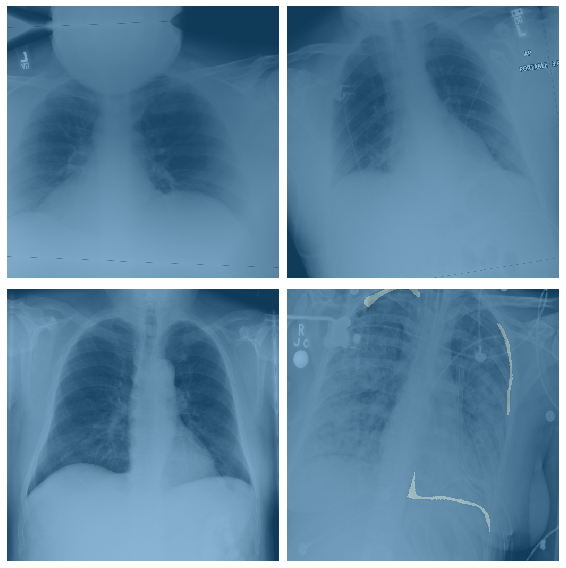

In [4]:
def get_data(fold):
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    valid_idx = list(kf.split(list(range(len(Path(TRAIN).ls())))))[fold][1]
    # Create databunch
    data = (SegmentationItemList.from_folder(TRAIN)
            .split_by_idx(valid_idx)
            .label_from_func(lambda x : str(x).replace('train', 'mask'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

In [5]:
# focal loss

import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.layers import FlattenedLoss

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.detach()].to(labels.device)

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=2., eps=1e-8):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
    # pred is flatten one hot array, while tgt is just a mask
    def forward(self, pred, tgt):
        t = one_hot_embedding(tgt, self.num_classes)
        t = t.transpose(-1, -1).contiguous().view(-1).float()
        
        x = F.softmax(pred.view(-1, 2), dim=-1).view(-1).float()
        
        pt = x * t + (1 - x) * (1 - t)
        pt = torch.clamp(pt, self.eps, 1. - self.eps)
        
        at = self.alpha * t + (1 - self.alpha) * (1 - t)
        w = at * (1 - pt).pow(self.gamma)
        
        l = -w * torch.log(pt + self.eps)

        return l.mean(dim=-1)
            
def FocalFlat(*args, axis:int=-1, floatify:bool=False, **kwargs):
    return FlattenedLoss(FocalLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)


In [5]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [6]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [7]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [8]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [9]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    preds, ys = learn.get_preds(ds_type)
    preds = preds[:,1,...]
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = learn.get_preds(ds_type)
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    del preds_lr
    gc.collect()
    torch.cuda.empty_cache()
    return preds, ys

In [ ]:
now = datetime.now()

for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data(fold)
    
    # create learner
    learn = unet_learner(data, models.resnet34, metrics=[dice])
    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    lr = 1e-3
    
    #fit the decoder part of the model keeping the encode frozen
    learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    
    # save model
    learn.save('unet_{}_fold{}'.format(now.strftime('%Y%m%d-%H%M%S'), fold));


fold:  0


epoch,train_loss,valid_loss,dice,time


## Eval

In [4]:
# load learner

learn = load_learner('./', 'unet_fold2_256_20190711-041009.pkl')


In [11]:
# Predictions for validation set

soft_masks_ = []
target_masks_ = []

with tqdm(total=len(data.valid_ds), file=sys.stdout) as pbar:
    for img, ys in data.valid_ds:
        pred = learn.predict(img)
        
        soft_masks_.append(pred[2][1].squeeze())
        target_masks_.append(ys.data.squeeze())
        
        pbar.update(1)


100%|██████████| 2135/2135 [00:58<00:00, 36.71it/s]


In [12]:
soft_masks = torch.stack(soft_masks_, dim=0).cuda()
target_masks = torch.stack(target_masks_, dim=0).cuda()

print('{}, {}'.format(soft_masks.shape, target_masks.shape))


torch.Size([2135, 256, 256]), torch.Size([2135, 256, 256])


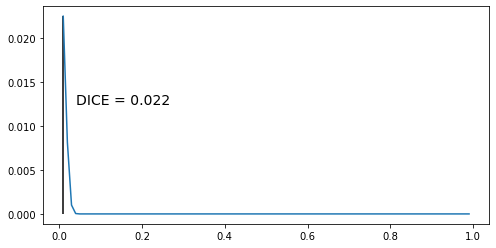

In [13]:
'''
def dice_overall(preds, targs):
    n = preds.shape[0]
    
    # preds = preds.view(-1)
    # targs = targs.view(-1)
    
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    
    u0 = union == 0.
    intersect[u0] = 1.
    union[u0] = 2.
    
    return (2. * intersect / union)
'''

def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(-1)
    targs = targs.view(-1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    return (2. * intersect / union)

# Find optimal threshold
dices = []

thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (soft_masks>i).long()
    dices.append(dice_overall(preds_m, target_masks).mean())
dices = np.array(dices)

best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))

plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()


In [46]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]

for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)

    ax1.set_title('Targets')
    ax2.set_title('Predictions')
    

AttributeError: 'ImageSegment' object has no attribute 'sum'

## Test

In [47]:
# load learner

learn = load_learner('./', 'export.pkl')


In [8]:
# Predictions for test set

soft_masks_ = []

with tqdm(total=len(data.test_ds), file=sys.stdout) as pbar:
    for img in data.test_ds:
        pred = learn.predict(img[0])
        soft_masks_.append(pred[2][1])
        
        pbar.update(1)
    

100%|██████████| 1377/1377 [01:44<00:00, 13.23it/s]


In [24]:
# convert to hard masks
print(best_thr)

soft_masks = torch.stack(soft_masks_, dim=0).squeeze()
hard_masks = (soft_masks>best_thr).to(dtype=torch.uint8).numpy()


0.45


In [18]:
# noise removal - threshold might be too high

noise_th = 75.0*(size/128.0)**2 #threshold for the number of predicted pixels

clean_masks = []

for hard_mask in progress_bar(hard_masks):
    if hard_mask.sum() >= noise_th:
        clean_masks.append(hard_mask)
    

In [25]:
# instance segmentation

mask_list = []

for p in progress_bar(clean_masks):
    # find out contours
    contours, hierarchy = cv2.findContours(p, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # create masks for contours
    masks = []

    for i in range(len(contours)):
        mask = np.zeros((256, 256))

        # draw a single mask from its contour
        cv2.drawContours(mask, contours, i, 1, -1)
        masks.append(mask)
        
    mask_list.append(masks)
    

In [26]:
# noise removal

noise_threshold = 30

clean_mask_list = []

for masks in progress_bar(mask_list):
    clean_masks = []
    
    for mask in masks:
        if mask.sum() >= noise_threshold:
            clean_masks.append(mask)
    
    clean_mask_list.append(clean_masks)

In [20]:
# use leakage!

sample_df = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# this part was taken from @raddar's kernel: https://www.kaggle.com/raddar/better-sample-submission
masks_ = sample_df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
masks_ = masks_.loc[masks_.N > 1].ImageId.values
###

ids = [o.stem for o in data.test_ds.items]
test_ids = list(sample_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)['ImageId'])

leakage_mask_list = []
leakage_id_list = []

for i, uid in enumerate(ids):
    if uid in test_ids:
        leakage_id_list.append(uid)
        
        if uid in masks_:
            leakage_mask_list.append(clean_mask_list[i])
        else:
            leakage_mask_list.append([])

In [21]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(masks):
    rles = []
    
    for mask in masks:
        im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        
        rle = mask2rle(im, 1024, 1024)
        rles.append(rle)
        
    return rles

pool = mp.Pool()
rle_list = pool.map(mask_worker, leakage_mask_list)

In [18]:
# Generate rle encodings (images are first converted to the original size)
rle_list = []

for p in progress_bar(clean_mask_list):
    rles = []
    
    for mask in p:
        im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        
        rle = mask2rle(im, 1024, 1024)
        rles.append(rle)
        
    rle_list.append(rles)
    

In [22]:
sub_list = []

count = 0

for uid, rles in zip(leakage_id_list, rle_list):
    if len(rles) > 0:
        for rle in rles:
            sub_list.append([uid, rle])
            count += 1
    else:
        sub_list.append([uid, ' -1'])

sub_df = pd.DataFrame(sub_list, columns=['ImageId', 'EncodedPixels'])
sub_df.head(5)

print(count)


21


In [23]:
sub_df.to_csv('unet_sub_{:.5f}.csv'.format(best_thr), index=False)
